In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import torch as th
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, GPT2LMHeadModel, GPT2DoubleHeadsModel
import re
from enum import Enum
import contractions as ct
from torch import nn

device = th.device("mps") if th.backends.mps.is_available() else th.device("cuda") if th.cuda.is_available() else th.device("cpu")

if device.type == "cuda":
    print(th.cuda.get_device_name(device))
else:
    print(device)

NVIDIA GeForce RTX 2070 SUPER


In [26]:
data_dir = "datasets/"

# Dataset paths
data_original = data_dir + "full/" # Use this for full dataset that contains all review matadata
data_pruned = data_dir + "pruned/" # Only datasets with one number to the right side of it have a pruned version
data_tokenized = data_dir + "tokenized/" # Only datasets with two numbers to the right side of it have a tokenized version

full = "All_Amazon_Review_5" # 80 GB
arts = "Arts_Crafts_and_Sewing" # 518 MB / 629 MB / 1.18 GB
video = "Amazon_Instant_Video_5" # 28 MB
gift = "Gift_Cards_5" # 0.88 MB

PAD_token = "<|pad|>"
BOS_token = "<|bos|>"
EOS_token = "<|eos|>"
UNK_token = "<|unk|>"

In [3]:
"""
DatasetType enum
- ORIGINAL: The original json dataset
- PRUNED: The pruned csv dataset
- TOKENIZED: The tokenized csv dataset
"""
class DatasetType(Enum):
    ORIGINAL = 0
    PRUNED = 1
    TOKENIZED = 2

listify = lambda x: x.split("|")
stringify = lambda x: "|".join(list(x.cast(pl.Utf8)))

"""
Normalizes strings by:
- Removing double spaces
- Converting to lower case
- Expanding contractions
"""
def normalize_text(text: str) -> str:
    return re.sub(r"\s+", " ", ct.fix(text.lower()))

"""
Normalizes the reviewText and summary columns of a dataframe by:
- Using normalize_text on the 'reviewText' and 'summary' columns
"""
def normalize_text_df(df: pl.DataFrame) -> pl.DataFrame:
    df = df.lazy().select([
        pl.col("reviewText").apply(normalize_text),
        pl.col("summary").apply(normalize_text),
        pl.exclude(["reviewText", "summary"])
    ]).collect()
    return df

"""
Prunes the dataset by:
- Removing reviews with a summary of "five stars", "four stars", "three stars", "two stars", or "one star
- Normalizing the reviewText and summary columns by the use of normalize_text_df
- Converting the overall column to a float between 0 and 1
"""
def prune(df: pd.DataFrame | pl.DataFrame) -> pl.DataFrame:
    # list of unwanted summaries in lower case
    if isinstance(df, pd.DataFrame):
        df = pl.DataFrame(df.dropna())
    assert(isinstance(df, pl.DataFrame))

    df = normalize_text_df(df)

    df = df.filter(pl.col("summary") != "five stars") \
           .filter(pl.col("summary") != "four stars") \
           .filter(pl.col("summary") != "three stars") \
           .filter(pl.col("summary") != "two stars") \
           .filter(pl.col("summary") != "one star")
    
    df = df.lazy().select([
        pl.col("overall").apply(lambda x: int(x)/5),
        pl.exclude(["overall"])
    ]).collect()
    return df.select([pl.col("reviewText"), pl.col("summary"), pl.col("overall")])

"""
Writes a dataframe to a csv file
- Distinguishes between polars and pandas dataframes
"""
def write_to_csv(df: pd.DataFrame | pl.DataFrame, path: str) -> None:
    if isinstance(df, pd.DataFrame):
        df.to_csv(path + ".csv", index=False)
    elif isinstance(df, pl.DataFrame):
        df.write_csv(path + ".csv")

"""
Tokenizes the reviewText and summary columns of a dataframe by:
- Using the tokenizer to encode the 'reviewText' and 'summary' columns
"""
def tokenize(df: pl.DataFrame, tokenizer: GPT2Tokenizer) -> pl.DataFrame:
    t = lambda x: tokenizer.encode(x, add_special_tokens=True)
    df = df.lazy().select([
        pl.col("reviewText").apply(t),
        pl.col("summary").apply(t),
        pl.exclude(["reviewText", "summary"])
    ]).collect()
    return df

"""
Loads a dataset from a csv file
- Distinguishes between polars and pandas dataframes
- Distinguishes between the original, pruned, and tokenized datasets
"""
def load_dataset(dataset: str, dataset_type: DatasetType, keep_cols = ["reviewText", "summary", "overall"]) -> pd.DataFrame | pl.DataFrame:
    if dataset_type == DatasetType.ORIGINAL:
        # return pl.read_json(data_original + dataset + ".json", json_lines=True).select([keep_cols])
        return pd.read_json(data_original + dataset + ".json", lines=True)[keep_cols]
    elif dataset_type == DatasetType.PRUNED:
        return pl.read_csv(data_pruned + dataset + ".csv", dtypes={"reviewtext": pl.Utf8, "summary": pl.Utf8, "overall": pl.Float32})
    elif dataset_type == DatasetType.TOKENIZED:
        df = pl.read_csv(data_tokenized + dataset + ".csv", dtypes={"reviewtext": pl.Utf8, "summary": pl.Utf8, "overall": pl.Float32})
        
        df = df.lazy().select([
            pl.col("reviewText").apply(listify).cast(pl.List(pl.Int64)),
            pl.col("summary").apply(listify).cast(pl.List(pl.Int64)),
            pl.exclude(["reviewText", "summary"])
        ]).collect()
        return df

"""
Saves a dataset to a csv file
- Distinguishes between the pruned and tokenized datasets
"""
def save_dataset(df: pl.DataFrame, dataset: str, dataset_type: DatasetType) -> None:
    if dataset_type == DatasetType.PRUNED:
        write_to_csv(df, data_pruned + dataset)
    elif dataset_type == DatasetType.TOKENIZED:
        
        df = df.lazy().select([
            pl.col("reviewText").apply(stringify),
            pl.col("summary").apply(stringify),
            pl.exclude(["reviewText", "summary"])
        ]).collect()
        write_to_csv(df, data_tokenized + dataset)

"""
Preprocesses a dataset by:
- Loading the dataset
- Pruning the dataset
- Tokenizing the dataset
"""
def preprocess(dataset: str, dataset_type: DatasetType, tokenizer, keep_cols = ["reviewText", "summary", "overall"], save_steps=True) -> pd.DataFrame | pl.DataFrame:
    if dataset_type == DatasetType.ORIGINAL:
        df = load_dataset(dataset, dataset_type, keep_cols)
        df = prune(df)
        if save_steps:
            save_dataset(df, dataset, DatasetType.PRUNED)
        df = tokenize(df, tokenizer)
        if save_steps:
            save_dataset(df, dataset, DatasetType.TOKENIZED)
        return df
    elif dataset_type == DatasetType.PRUNED:
        df = load_dataset(dataset, dataset_type)
        df = tokenize(df, tokenizer)
        if save_steps:
            save_dataset(df, dataset, DatasetType.TOKENIZED)
        return df
    elif dataset_type == DatasetType.TOKENIZED:
        df = load_dataset(dataset, dataset_type)
        return df

In [4]:
# Prune and save
df = load_dataset(gift, DatasetType.ORIGINAL)
df = prune(df)
save_dataset(df, gift, DatasetType.PRUNED)

In [7]:
# Tokenize and save
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
df = load_dataset(gift, DatasetType.PRUNED)
print(df["reviewText"][-1])
print(df["summary"][-1])
print(df["overall"][-1])

df = tokenize(df, tokenizer)
print(df.tail())

print("|".join(list(df["reviewText"][0].cast(pl.Utf8))))
save_dataset(df, gift, DatasetType.TOKENIZED)

not much to say, gift card is as good as cash!
gift card is as good as cash
1.0
shape: (5, 3)
┌────────────────────┬──────────────────────┬─────────┐
│ reviewText         ┆ summary              ┆ overall │
│ ---                ┆ ---                  ┆ ---     │
│ list[i64]          ┆ list[i64]            ┆ f32     │
╞════════════════════╪══════════════════════╪═════════╡
│ [5661, 373, ... 0] ┆ [7079, 540, 0]       ┆ 1.0     │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [1662, 881, ... 0] ┆ [70, 2135, ... 5003] ┆ 1.0     │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [70, 2135]         ┆ [18223, 6979]        ┆ 1.0     │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [37784, 922, 0]    ┆ [37784, 922, 0]      ┆ 1.0     │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ [1662, 881, ... 0] ┆ [70, 2135, ... 5003] ┆ 1.0     │
└────────────────────┴──────────────────────┴─────────┘
70|2135|2657|329|616|4957


In [8]:
# Load the tokenized data
df = load_dataset(gift, DatasetType.TOKENIZED)
df.tail()

reviewText,summary,overall
list[i64],list[i64],f32
"[5661, 373, ... 0]","[7079, 540, 0]",1.0
"[1662, 881, ... 0]","[70, 2135, ... 5003]",1.0
"[70, 2135]","[18223, 6979]",1.0
"[37784, 922, 0]","[37784, 922, 0]",1.0
"[1662, 881, ... 0]","[70, 2135, ... 5003]",1.0


In [9]:
# df = load_dataset(arts, DatasetType.TOKENIZED)

# Find max length of review text with numpy
max_review_len = np.max(list(df['reviewText'].apply(list).apply(len)))
print("\nMax length of review text: ", max_review_len)
# Find max length of summary with numpy
max_summary_len = np.max((list(df['summary'].apply(list).apply(len))))
print("Max length of summary: ", max_summary_len)


Max length of review text:  553
Max length of summary:  27


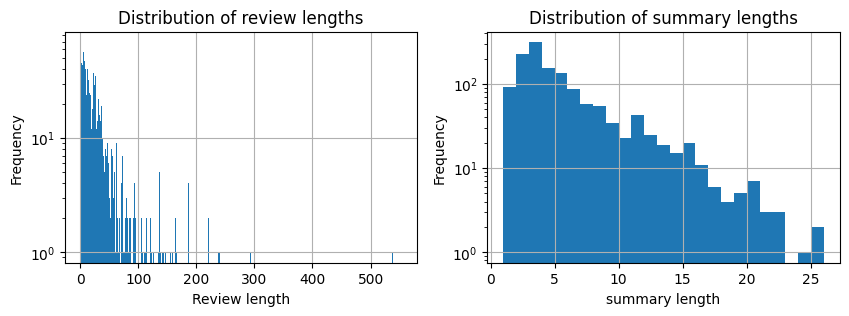

In [10]:
# df = preprocess(arts, DatasetType.ORIGINAL, tokenizer)

# Plot a distribution of review lengths with log scale
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

r_counts, r_bins = np.histogram(df["reviewText"].apply(len), bins=100)
s_counts, s_bins = np.histogram(df["summary"].apply(len), bins=100)

r_vcounts = df["reviewText"].apply(len).value_counts()
s_vcounts = df["summary"].apply(len).value_counts()
r_vbins = list(r_vcounts["reviewText"])
s_vbins = list(s_vcounts["summary"])

log_yscale = True

ax[0].hist(df["reviewText"].apply(len), bins=range(np.min(r_vbins), np.max(r_vbins)), log=log_yscale)
ax[0].set_title("Distribution of review lengths")
ax[0].set_xlabel("Review length")
ax[0].set_ylabel("Frequency")
ax[0].grid()

ax[1].hist(df["summary"].apply(len), bins=range(np.min(s_vbins), np.max(s_vbins)), log=log_yscale)
ax[1].set_title("Distribution of summary lengths")
ax[1].set_xlabel("summary length")
ax[1].set_ylabel("Frequency")
ax[1].grid()

plt.show()

In [11]:
print(pl.DataFrame.estimated_size(df))
print(len(df))

382820
1345


In [27]:
t = GPT2Tokenizer.from_pretrained("gpt2", pad_token=PAD_token, bos_token=BOS_token, eos_token=EOS_token, unk_token=UNK_token, add_bos_token=False, add_prefix_space=True, trim_offsets=True)
# t.add_special_tokens({'pad_token': '<pad>'})
# t.add_special_tokens({'bos_token': '<bos>'})
# t.add_special_tokens({'eos_token': '<eos>'})

sentences = [
    "I'm.",
    "i'm.",
    "I am."
]

sentences = [
    " ".join([
        ct.fix(word)
        for word in sentence.split()
    ]).lower()
    for sentence in sentences
]

# sentences = "one sentence"

tokenized = t(sentences, add_special_tokens = True, padding = "max_length", truncation = True, max_length=10, return_tensors = "pt")
print(tokenized)

decoding = lambda x, t, **kwargs : t.decode(x, kwargs) if isinstance(x, list) or isinstance(x, tuple) else t.batch_decode(x["input_ids"], kwargs)

# detokenized = t.batch_decode(tokenized["input_ids"], skip_special_tokens=True, clean_up_tokenization_spaces=True)
detokenized = decoding(tokenized, t, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print(detokenized)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': tensor([[ 1312,   716,    13, 50259, 50259, 50259, 50259, 50259, 50259, 50259],
        [ 1312,   716,    13, 50259, 50259, 50259, 50259, 50259, 50259, 50259],
        [ 1312,   716,    13, 50259, 50259, 50259, 50259, 50259, 50259, 50259]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}
[' i am.', ' i am.', ' i am.']


In [13]:
# torch dataset from pandas dataframe
# defines a voacbulary of words and converts the review text to a list of indices
# beware of symbols like ., !, ? etc.
# pad the review text and summary to max_review_len and max_summary_len respectively

"""
ReviewDataset pytorch dataset interface
- expects a polars dataframe with columns reviewText, summary, overall
- expects it in the DatasetType.PRUNED format
- expects a GPT2Tokenizer
"""
class ReviewDataset(th.utils.data.Dataset):
    def __init__(self, df: pl.DataFrame, tokenizer: GPT2Tokenizer, dataset_type = DatasetType.PRUNED, max_review_len = 2000, max_summary_len = 200, lower_case = True, device = "cpu"):
        self.df = df
        self.dataset_type = dataset_type
        self.max_review_len = max_review_len
        self.max_summary_len = max_summary_len
        self.tokenizer = tokenizer
        self.lower_case = lower_case
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df["reviewText"][idx]
        summary = self.df["summary"][idx]
        rating = th.tensor(self.df["overall"][idx])

        # Tokenize the review and summary strings
        review = self.tokenizer.encode(review, add_special_tokens = True, padding = "max_length", truncation = True, max_length=self.max_review_len, return_tensors = "pt").squeeze()
        summary = self.tokenizer.encode(summary, add_special_tokens = True, padding = "max_length", truncation = True, max_length=self.max_summary_len, return_tensors = "pt").squeeze()

        # move tensors to device
        review = review.to(self.device)
        summary = summary.to(self.device)
        rating = rating.to(self.device)
        
        return review, summary, rating
    
    def detokenize(self, x: th.Tensor):
        return self.tokenizer.decode(x, skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [36]:
# test the ReviewDataset class
t = GPT2Tokenizer.from_pretrained("gpt2", pad_token="<|pad|>", bos_token="<|bos|>", eos_token="<|eos|>", unk_token="<|unk|>", add_bos_token=False, add_prefix_space=True, trim_offsets=True)
idx = 45
df = load_dataset(gift, DatasetType.PRUNED)
dataset = ReviewDataset(df, t, max_review_len=max_review_len, max_summary_len=max_summary_len, device=device)
# print(dataset[45])
# test the detokenize method
# print(dataset.detokenize(dataset[45][0]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
# df = load_dataset(gift, DatasetType.PRUNED)

# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer.add_special_tokens({"pad_token": PAD_token})
# # tokenizer.add_special_tokens({"eos_token": "<|eos|>"})
# # tokenizer.add_special_tokens({"bos_token": "<|bos|>"})

# # I'm
# # i'm
# # I am

# idx = 38

# review = df["reviewText"][idx]
# review = ct.fix(review.lower())
# summary = df["summary"][idx]
# summary = ct.fix(summary.lower())

# print(review)
# print(summary)
# review_tokenized = tokenizer(review, return_tensors="pt", padding="max_length", truncation=True, max_length=max_review_len)
# summary_tokenized = tokenizer(summary, return_tensors="pt", padding="max_length", truncation=True, max_length=max_summary_len)

# print(review_tokenized)
# print(summary_tokenized)

In [32]:
# test the dataset
dataset = ReviewDataset(df, t, max_review_len = max_review_len, max_summary_len = max_summary_len, lower_case = False)

data_idx = 45

# decode
print(f"Review: {ReviewDataset.detokenize(dataset, dataset[data_idx][0])}")
print(f"Summary: {ReviewDataset.detokenize(dataset, dataset[data_idx][1])}")
print(f"Rating: {int(dataset[data_idx][2])}")

# max length is the max index of the vocabulary
MAX_LENGTH = t.vocab_size
print(f"MAX_LENGTH: {MAX_LENGTH}")

Review:  what is to go wrong with a gift card. as long as it enters into a person's account as a credit it is just what you paid for.
Summary:  gift card
Rating: 1
MAX_LENGTH: 50257


In [31]:
""" # Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2DoubleHeadsModel.from_pretrained("gpt2")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Define the text you want to embed
text = "Hello, world!"

# Encode the text using the GPT-2 model
embedding, _ = model(tokenizer(text))


# Print the shape of the resulting embedding
# print(embedding.shape)  # (1, 13, 768) """

' # Initialize the tokenizer and model\ntokenizer = GPT2Tokenizer.from_pretrained("gpt2")\nmodel = GPT2DoubleHeadsModel.from_pretrained("gpt2")\n\ntokenizer = GPT2Tokenizer.from_pretrained("gpt2")\n\n# Define the text you want to embed\ntext = "Hello, world!"\n\n# Encode the text using the GPT-2 model\nembedding, _ = model(tokenizer(text))\n\n\n# Print the shape of the resulting embedding\n# print(embedding.shape)  # (1, 13, 768) '

In [41]:
"""
Model
uses context aware word embedding
multi-task network

Input: takes in a review string
Task 1: output a summary string of the input review with a max length defined by the dataset
Task 2: output a rating of the input review as a float 0-1

Use an encoder decoder setup with one decoder for each task
"""

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        print(input.get_device())
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return th.zeros(1, 1, self.hidden_size, device=device)


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = nn.softmax(
            self.attn(th.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = th.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = th.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = nn.relu(output)
        output, hidden = self.gru(output, hidden)

        output = nn.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return th.zeros(1, 1, self.hidden_size, device=device)

In [40]:
# test the model
hidden_size = 256
encoder1 = EncoderRNN(MAX_LENGTH, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, MAX_LENGTH, dropout_p=0.1).to(device)

# single forward pass test
input_tensor = dataset[0][0]
target_tensor = dataset[0][1]

encoder_hidden = encoder1.initHidden()

encoder_outputs = th.zeros(MAX_LENGTH, encoder1.hidden_size, device=device)

for ei in range(input_tensor.size(0)):
    encoder_output, encoder_hidden = encoder1(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] += encoder_output[0, 0]

decoder_input = th.tensor([[]], device=device)  # SOS


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [54]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

#from pytorch_transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Set the device
device = "cpu"

# Load the GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = model.to(device)

# Generate a summary
#prompt = "Airbags are safety devices that are installed in vehicles to protect passengers in the event of a collision. When a collision occurs, sensors detect the impact and deploy the airbag, which inflates quickly to cushion the passengers and prevent them from being thrown forward or to the side. Airbags are typically located in the steering wheel and dashboard for the driver, and in the doors and roof pillars for the passengers. They are designed to deploy in a specific sequence to maximize the protection they provide. Modern airbags use advanced sensors and algorithms to tailor their deployment to the specific type and severity of the collision."
prompt = "This is the full text that you want to summarize."
encoded_prompt = tokenizer(prompt)
print(encoded_prompt)
inputs = torch.tensor(encoded_prompt["input_ids"]).unsqueeze(0).to(device)

outputs = model.generate(
    inputs,
    max_length=len(inputs) // 2,  # Half the length of the encoded input text
    temperature=0.5,
    top_k=50,
    top_p=0.9,
    repetition_penalty=1.0,
    do_sample=True,
    num_return_sequences=1,
    attention_mask=encoded_prompt["attention_mask"],
)
print("Output: ")
# Print the generated summary
print(tokenizer.decode(outputs[0]))
print(f"The origianl text is {len(encoded_prompt)} tokens long, and the generated summary is {len(outputs[0])} tokens long.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 11, but `max_length` is set to 11. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


{'input_ids': [1212, 318, 262, 1336, 2420, 326, 345, 765, 284, 35743, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
11


AttributeError: 'list' object has no attribute 'index_select'

In [46]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Load the GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Encode a text input
input_text = "The quick brown fox jumps over the lazy dog."
input_ids = tokenizer.encode(input_text)

# Set the attention mask and pad token id
attention_mask = input_ids.(tokenizer.pad_token_id).long()
pad_token_id = tokenizer.pad_token_id

# Generate a response from the model
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    pad_token_id=pad_token_id
)

# Print the encoded text
print(outputs)

AttributeError: 'list' object has no attribute 'ne'

In [ ]:
"""
Dataset preparation
Use the ReviewDataset to create a DataLoader
Splitting the train, validation, and test sets
"""
# initialise the dataset
dataset = ReviewDataset(df)
dataset_size = len(dataset)

# shrink dataset for testing
dataset_size = 500
dataset = th.utils.data.Subset(dataset, range(dataset_size))

# split the dataset
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = th.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create the dataloaders
batch_size = 32
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = th.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# test the dataloader
train_loader_iter = iter(train_loader)
x, y, z = next(train_loader_iter)
print(x.shape, y.shape, z.shape)


torch.Size([32, 18152]) torch.Size([32]) torch.Size([32, 151])


In [ ]:
"""
Training
"""
""" # initialise the model
# take into account if it is a subset of the dataset
model = Summariser(dataset.dataset.vocab_size, 256, max_review_len, max_summary_len)
model = model.to(device)

# define the loss functions
loss_fn1 = th.nn.CrossEntropyLoss()
loss_fn2 = th.nn.BCELoss()

# define the optimiser
optimiser = th.optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
epochs = 10

# train the model
for epoch in range(epochs):
    for review, rating, summary in train_loader:
        # zero the gradients
        optimiser.zero_grad()

        # forward pass
        y_pred1, y_pred2 = model(review)

        # calculate the loss
        loss1 = loss_fn1(y_pred1, summary)
        loss2 = loss_fn2(y_pred2, rating.unsqueeze(1).float())
        loss = loss1 + loss2

        # backward pass
        loss.backward()

        # update the weights
        optimiser.step()

    # print the loss
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}') """
